In [1]:
import sys
sys.path.append('..')

# OS
import os
import argparse
import gc
import argparse
from argparse import Namespace
import pickle
from copy import deepcopy
from tqdm import tqdm

# mathematics
import numpy as np
import random
import matplotlib.pyplot as plt

# data handling
import pandas as pd

# Torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

# Torchvision
import torchvision

# logging
# import wandb

# my_lib
from model.net import *
# from model.train import train, validate, test
from misc.utils import save_checkpoint, load_transform, load_dataset


In [ ]:
# loss
def loss(theta, H, L0=0.001):
    """Quadratic loss function
     L = 0.5 * theta^T H theta """
    
    L = 0.5 * torch.einsum('ni, ij, nj->n', theta, H, theta)  # quadratic loss
    return L + L0

# Gradient of the loss
def grad(theta, H):
    return torch.einsum('ij, nj->ni', H, theta)  # gradient of the quadratic loss

# L = torch.linalg.cholesky(H + 1e-5 * torch.eye(2))  # jitter for numerical stability

torch.random.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

eta = 0.1 # learning rate
num_trajs = 1000
num_steps = 5000
batch_size = 10
dim = 40

H0 = torch.diag(torch.linspace(10, 1, dim))  # covariance matrix (diagonal)

# Initialization (close to minimum)
theta = torch.randn(num_trajs, dim) * 0.1  # initial theta (close to the minimum)
# theta[:, 0] = torch.rand(num_trajs)/2 - 0.25  # theta_0 is uniform in [-0.25, 0.25]
trajs = np.zeros((num_trajs, num_steps, dim))  # trajectory of theta
trajs_noise = np.zeros((num_trajs, num_steps, dim))  # trajectory of theta

for it in range(num_steps//4):
    g = grad(theta, H0)

    loss_theta = loss(theta, H0)  # loss function
    noise_cov = loss_theta[:, None, None] * H0  # noise covariance
    noise = np.einsum('nij, nj->ni', torch.sqrt(noise_cov), torch.randn(num_trajs, dim))
    theta = theta - eta * g + eta/(np.sqrt(batch_size)) * noise

for it in range(num_steps):
    g = grad(theta, H0)

    loss_theta = loss(theta, H0)  # loss function
    noise_cov = loss_theta[:, None, None] * H0  # noise covariance
    noise = np.einsum('nij, nj->ni', torch.sqrt(noise_cov), torch.randn(num_trajs, dim))
    theta = theta - eta * g + eta/(np.sqrt(batch_size)) * noise
    trajs[:, it, :] = theta.clone().numpy()
    trajs_noise[:, it, :] = noise.clone().numpy()



In [157]:
losses = np.array([loss(torch.tensor(trajs[0]).type(torch.float32), H0) for theta in trajs])  # loss function
print(losses.mean())

0.0068658898


In [158]:
eta * torch.trace(H0)/(2*batch_size)

tensor(1.1000)

In [159]:
trajs_noise.var(axis=0).mean(axis=0)

array([0.07014054, 0.06858544, 0.06694263, 0.0653855 , 0.06383093,
       0.06209774, 0.06049969, 0.05890161, 0.05728375, 0.05560475,
       0.05406603, 0.05240848, 0.0507355 , 0.0492201 , 0.0475804 ,
       0.04588862, 0.04433445, 0.04270751, 0.04104917, 0.03948293,
       0.03775205, 0.03616367, 0.0346129 , 0.03294988, 0.03133709,
       0.02970941, 0.02811042, 0.02646256, 0.02487155, 0.02321874,
       0.02161338, 0.01998449, 0.01835952, 0.01676805, 0.01512929,
       0.01349027, 0.01187785, 0.01026444, 0.00864023, 0.00701917])

In [160]:
cov = trajs.var(axis=0).mean(axis=0)

(H0[np.diag_indices_from(H0)] @ cov) * H0[np.diag_indices_from(H0)]

# (torch.trace(H0 @ cov) * H0)[np.diag_indices_from(H0)]

tensor([0.1205, 0.1177, 0.1149, 0.1122, 0.1094, 0.1066, 0.1038, 0.1010, 0.0983,
        0.0955, 0.0927, 0.0899, 0.0871, 0.0844, 0.0816, 0.0788, 0.0760, 0.0732,
        0.0704, 0.0677, 0.0649, 0.0621, 0.0593, 0.0565, 0.0538, 0.0510, 0.0482,
        0.0454, 0.0426, 0.0399, 0.0371, 0.0343, 0.0315, 0.0287, 0.0260, 0.0232,
        0.0204, 0.0176, 0.0148, 0.0121])

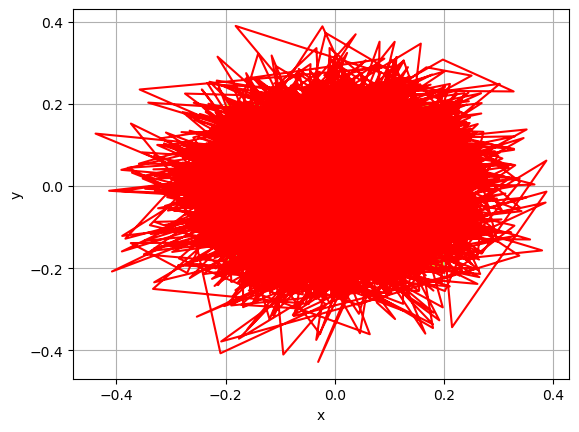

In [101]:
# Plotting the trajectory over contours
# x_vals = np.linspace(-0.2, 0.2, 100)
# y_vals = np.linspace(-0.2, 0.2, 100)
# X, Y = np.meshgrid(x_vals, y_vals)
# Z = 0.5 * X**2 + Y**2

plt.contour(X, Y, Z, levels=30, cmap="viridis")
# plt.plot(trajectory[:, 0], trajectory[:, 1], color='red', marker='o', markersize=2, linewidth=1)
# plt.title("SGD Dynamics Near a Local Minimum")
idx = 15
plt.plot(trajs[idx, :, 0].flatten(), trajs[idx, :, 2].flatten(), c='red', alpha=1)
# plt.plot(trajs[:, :, 0].flatten(), trajs[:, :, 1].flatten(), c='red', alpha=1)

plt.xlabel("x")
plt.ylabel("y")
# plt.axis('equal')
plt.grid(True)
# plt.show()

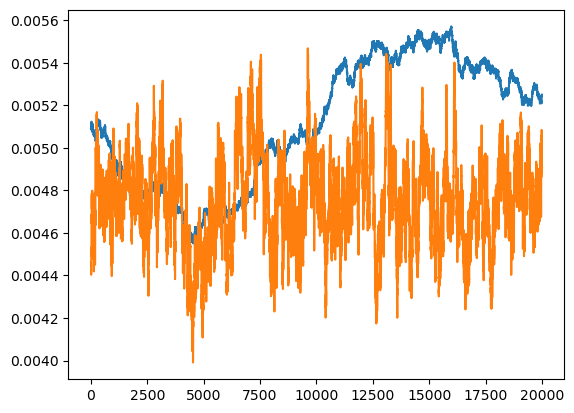

In [141]:
trajs_1 = (trajs[:, :, 0] < 0.1) * (trajs[:, :, 0] > -0.1)

vars = trajs**2

plt.plot(vars.mean(axis=0)[:, 0])
plt.plot(vars.mean(axis=0)[:, 1])

(array([3.13744278e-04, 1.42836211e-03, 3.14569921e-03, 3.38513563e-03,
        7.62068338e-03, 4.16123989e-03, 1.02627405e-02, 2.23336387e-02,
        2.07318916e-02, 2.63710322e-02, 4.98853402e-02, 6.72238397e-02,
        9.37187183e-02, 9.46682076e-02, 1.03040226e-01, 1.24184939e-01,
        1.47657965e-01, 2.08136303e-01, 2.66938585e-01, 3.08831703e-01,
        3.68905476e-01, 4.24925342e-01, 5.29781982e-01, 6.05452148e-01,
        7.17202906e-01, 8.16907535e-01, 9.95692235e-01, 1.18631665e+00,
        1.39233931e+00, 1.60442218e+00, 1.93116208e+00, 2.18221530e+00,
        2.47185906e+00, 2.75313906e+00, 2.97437832e+00, 3.18216785e+00,
        3.50206317e+00, 3.84354904e+00, 3.99164460e+00, 4.29522521e+00,
        4.56348483e+00, 4.67986744e+00, 4.94527859e+00, 5.27031766e+00,
        5.46516937e+00, 5.48180607e+00, 5.26708114e+00, 5.25597624e+00,
        5.28602139e+00, 5.37459635e+00, 5.29557407e+00, 5.10606427e+00,
        4.97951800e+00, 4.89985172e+00, 4.69817194e+00, 4.513434

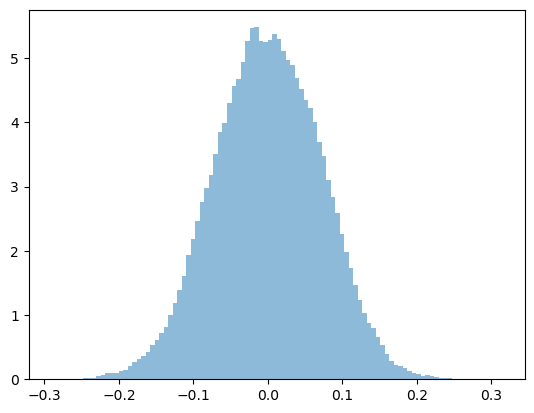

In [ ]:
plt.hist(trajs[:, :, 0].flatten(), bins=100, density=True, alpha=0.5, label='x')
plt.plot()